In [2]:
# !pip install numpy==1.23.5
import matplotlib.pyplot as plt
import os
import sys

args = 2
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel

print('Jax version:        ', jax.__version__)
print('Python version:     ', sys.version)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

Selected GPU 2
Jax version:         0.4.16
Python version:      3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]
Jax default backend: gpu
Jax devices:         [gpu(id=0)]


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append('/home/davcic/CP_Testing')

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod

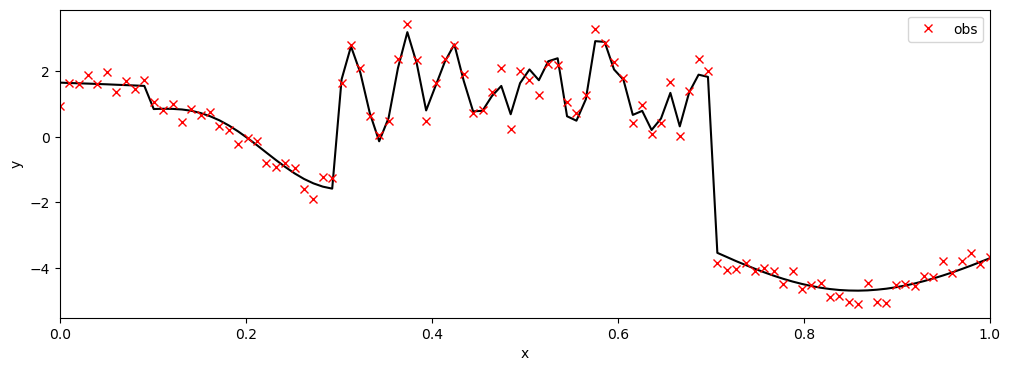

In [4]:
key = jrnd.PRNGKey(12345)

lengthscale_ = jnp.array([0.5, 0.1, 0.01, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.3
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([30, 10, 70])/n
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        CP=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

In [5]:
num_CP = 3
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel)

priors = dict(kernel=dict(lengthscale=dx.Uniform(low = jnp.zeros(num_CP+1),
                                                 high = jnp.zeros(num_CP+1)+1),
                          variance=dx.Uniform(low = jnp.zeros(num_CP+1),
                                                 high = jnp.zeros(num_CP+1)+5),
                          CP=dx.Uniform(low=jnp.zeros(num_CP),
                                        high=jnp.ones(num_CP))
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())))

gp_marginal = FullMarginalGPModel(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()
gp_latent = FullLatentGPModel(x, y, cov_fn=kernel, priors=priors)  # Defaults to likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

In [6]:
%%time

key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
CPU times: user 34.7 s, sys: 16.7 s, total: 51.3 s
Wall time: 57.2 s


Text(0, 0.5, 'variance')

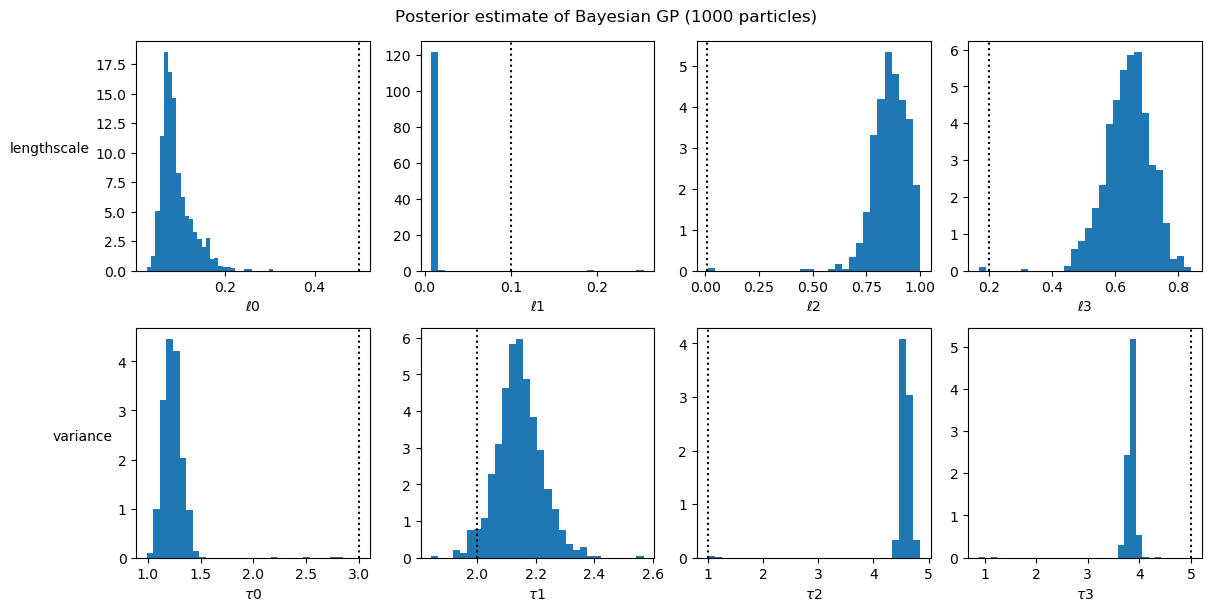

In [7]:
trainables = ['lengthscale', 'variance']

num_params = len(trainables)

symbols = dict(lengthscale='\ell',
            variance=r'\tau')

_, axes = plt.subplots(nrows=num_params, ncols=num_CP+1, constrained_layout=True,
                    figsize=(12, 6))


particles = mgp_particles
tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
            variance=particles.particles['kernel']['variance'],
            )
for j, var in enumerate(trainables):
    pd = tr[var]
    # There are some outliers that skew the axes
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    pd_filtered = jnp.extract(pd>pd_l, pd)
    pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    for i in range(num_CP+1):
      axes[j, i].hist(pd[:, i], bins=30, density=True, color='tab:blue')
      axes[j, i].axvline(x=ground_truth[var][i], ls=':', c='k')

      if var in symbols:
          axes[j, i].set_xlabel(r'${:s}$'.format(symbols[var]+ str(i)))



plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('lengthscale', rotation=0, ha='right')
axes[1, 0].set_ylabel('variance', rotation=0, ha='right')

Text(0, 0.5, 'Marginal GP')

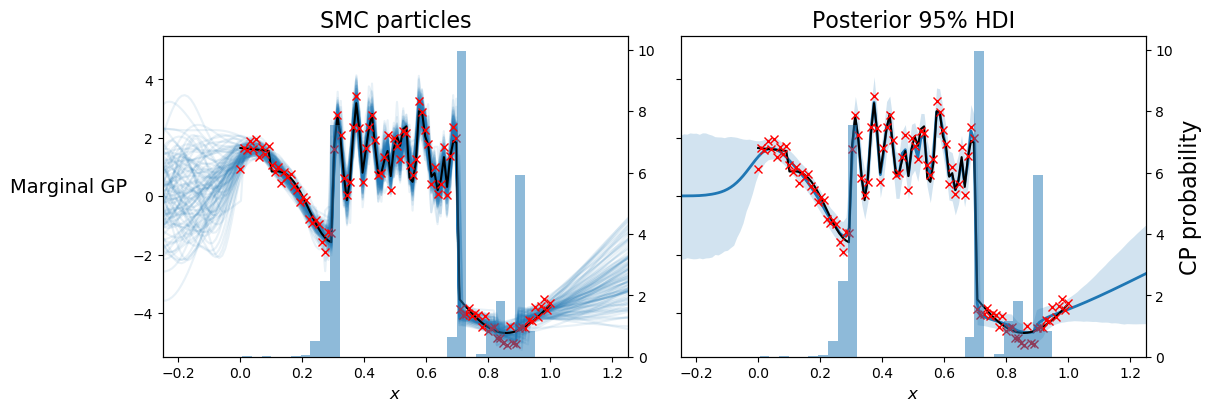

In [8]:
x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
f_pred = gp_marginal.predict_f(key_pred, x_pred)

pd = mgp_particles.particles['kernel']['CP']
# There are some outliers that skew the axis
pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
pd_filtered = jnp.extract(pd>pd_l, pd)
pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
f_mean = jnp.mean(f_pred, axis=0)
f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)


Trying to learn the amount of CP (hyper poisson Process)


In [5]:
from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from New_kernel_1 import Discontinuous_multiple_params_hyper_periodic
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod

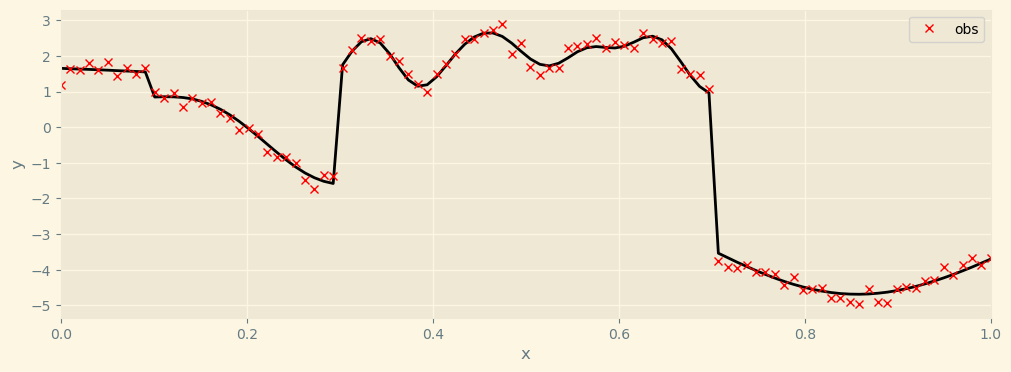

In [7]:
key = jrnd.PRNGKey(12345)

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

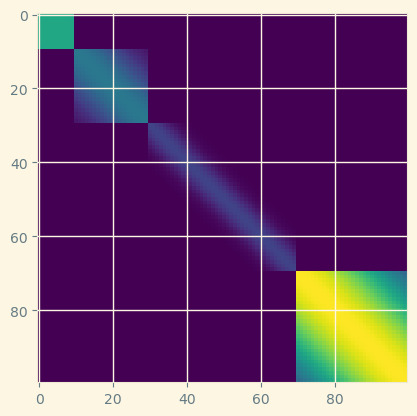

In [8]:
plt.style.use('Solarize_Light2')
plt.imshow(K)

In [7]:
size = 10
T = 1
max_CP = size
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params_hyper(base_kernel)

priors = dict(kernel=dict(
                          # lengthscale=Uniform_mod(low = jnp.zeros(max_CP+1),
                          #                        high = jnp.zeros(max_CP+1)+1),
                          # variance=Uniform_mod(low = jnp.zeros(max_CP+1),
                          #                        high = jnp.zeros(max_CP+1)+5),
                          lengthscale=LogNormal_mod(0, 2, max_CP+1),
                          variance=LogNormal_mod(0.5, 1, max_CP+1), 
                        #   lengthscale=dx.Transformed(dx.MultivariateNormalFullCovariance(jnp.zeros(max_CP),
                        #                                                                  jnp.eye(max_CP)), 
                        #                              dx.Block(tfb.Exp(), 1)),
                        #   variance=dx.Transformed(dx.MultivariateNormalFullCovariance(jnp.zeros(max_CP),
                        #                                                               jnp.eye(max_CP)),
                        #                           dx.Block(tfb.Exp(), 1)),
                          num=Poisson_Process_hyper(size, T)
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())),
              hyper = dict(hyper_pp = dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp())))

gp_marginal = FullMarginalGPModelhyper_mult(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

num_particles = 1_000
num_mcmc_steps = 100

In [1]:
# sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)
# mode='gibbs-in-smc'
# key, gpm_key = jrnd.split(key)
# key_init = gpm_key

# steps = 10
# from jax import Array
# from typing import Any, Union, NamedTuple, Dict, Any, Iterable, Mapping, Callable
# from blackjax import adaptive_tempered_smc, rmh
# import blackjax.smc.resampling as resampling
# from uicsmodels.sampling.inference import inference_loop, smc_inference_loop, smc_inference_loop_trace

# from jax.tree_util import tree_flatten, tree_unflatten, tree_map
# from distrax._src.distributions.distribution import Distribution
# from distrax._src.bijectors.bijector import Bijector

# ArrayTree = Union[Array, Iterable["ArrayTree"], Mapping[Any, "ArrayTree"]]
# class GibbsState(NamedTuple):

#     position: ArrayTree

# if sampling_parameters is None:
#     sampling_parameters = dict()

# if mode == 'gibbs-in-smc' and not (hasattr(gp_marginal, 'gibbs_fn') and callable(gp_marginal.gibbs_fn)):
#     # print("test")
#     sigma = 0.01
#     print(f'No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = {sigma:.2f}') 
#     mode = 'mcmc-in-smc'
#     priors_flat, _ = tree_flatten(gp_marginal.param_priors, lambda l: isinstance(l, (Distribution, Bijector)))
#     m = 0            
#     for prior in priors_flat:
#         # print(prior.batch_shape)
#         m += jnp.prod(jnp.asarray(prior.batch_shape)) if prior.batch_shape else 1
#     sampling_parameters['kernel'] = rmh
#     sampling_parameters['kernel_parameters'] = dict(sigma=sigma*jnp.eye(m))


# # Set up tempered MCMC kernel
# def mcmc_step_fn(key, state, temperature, **mcmc_parameters):
#     def apply_mcmc_kernel(key, logdensity, pos):
#         kernel = kernel_type(logdensity, **kernel_parameters)
#         state_ = kernel.init(pos)
#         # print(state_)
#         state_, info = kernel.step(key, state_)
#         return state_.position, info
    
#     #
#     position = state.position.copy()
#     # print(position)
#     loglikelihood_fn_ = gp_marginal.loglikelihood_fn()
#     logprior_fn_ = gp_marginal.logprior_fn()
#     logdensity = lambda state: temperature * loglikelihood_fn_(state) + logprior_fn_(state)
#     new_position, info_ = apply_mcmc_kernel(key, logdensity, position)
#     return GibbsState(position=new_position), None  

# #
# kernel_type = sampling_parameters.get('kernel')
# kernel_parameters = sampling_parameters.get('kernel_parameters')
# mcmc_init_fn = gp_marginal.smc_init_fn

# #Set up adaptive tempered SMC
# smc = adaptive_tempered_smc(
#     logprior_fn=gp_marginal.logprior_fn(),
#     loglikelihood_fn=gp_marginal.loglikelihood_fn(),
#     mcmc_step_fn=mcmc_step_fn,
#     mcmc_init_fn=mcmc_init_fn,
#     mcmc_parameters=sampling_parameters.get('mcmc_parameters', dict()),
#     resampling_fn=resampling.systematic,
#     target_ess=sampling_parameters.get('target_ess', 0.5),
#     num_mcmc_steps=sampling_parameters.get('num_mcmc_steps', 100)
#     )
# num_particles = sampling_parameters.get('num_particles', 1_000)
# include_trace = sampling_parameters.get('include_trace', False)
# initial_particles = gp_marginal.init_fn(key_init,
#                                 num_particles=num_particles)
# initial_smc_state = smc.init(initial_particles.position)   
# key, key_inference = jrnd.split(key_init)
# print(initial_smc_state.position.copy())
# for i in range(steps):
# # key, key_inference = jrnd.split(key_init)
# initial_smc_state = smc.step(key_inference, initial_smc_state)
# if include_trace:
#     smc_output = smc_inference_loop_trace(key_inference,
#                                             smc.step,
#                                             initial_smc_state)
#     num_iter, particles, marginal_likelihood, trace = smc_output
# else:
# smc_output = smc_inference_loop(key_inference,
#                                 smc.step,
#                                 initial_smc_state)
# num_iter, particles, marginal_likelihood = smc_output

In [8]:
%%time
num_particles = 1000
num_mcmc_steps = 100
key, gpm_key = jrnd.split(key)
mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps),
                                                                  poisson = True)

No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
CPU times: user 2min 43s, sys: 530 ms, total: 2min 43s
Wall time: 2min 40s


In [30]:
# print(mgp_particles.particles['kernel']['lengthscale'])
# print(mgp_particles.particles['kernel']['num'])
# print(mgp_particles.particles['kernel']['variance'])
# print(mgp_particles.particles['hyper']['hyper_pp'])

Text(0, 0.5, 'variance')

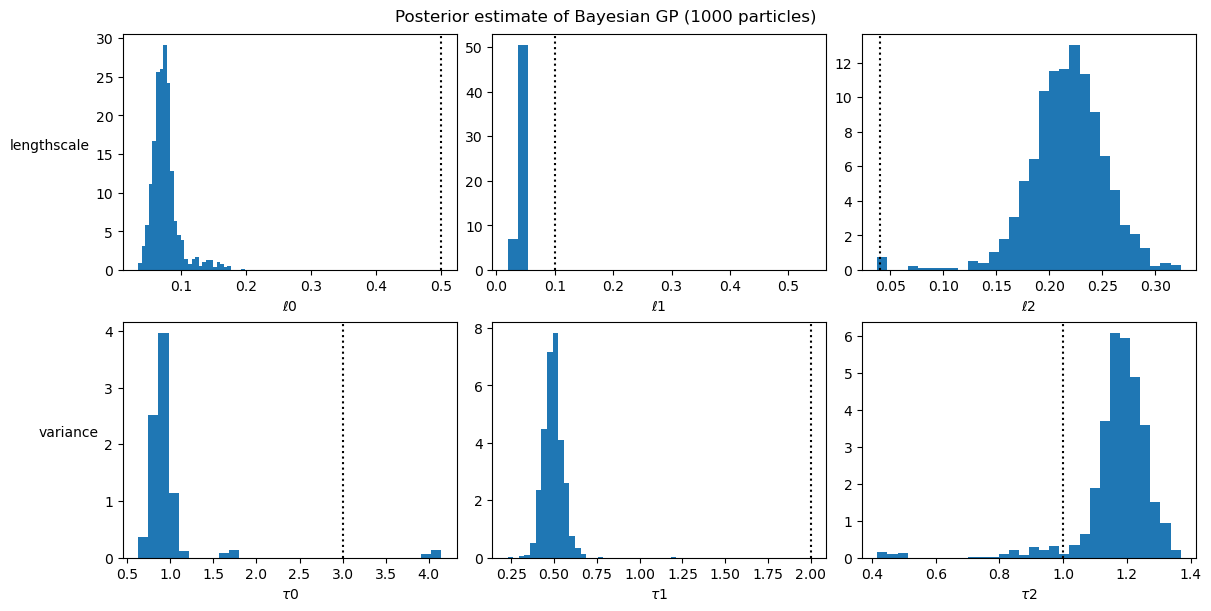

In [16]:
trainables = ['lengthscale', 'variance']

num_params = len(trainables)

symbols = dict(lengthscale='\ell',
            variance=r'\tau')
num_CP = 2
_, axes = plt.subplots(nrows=num_params, ncols=num_CP+1, constrained_layout=True,
                    figsize=(12, 6))


particles = mgp_particles
tr = dict(lengthscale=particles.particles['kernel']['lengthscale'],
            variance=particles.particles['kernel']['variance'],
            )
for j, var in enumerate(trainables):
    pd = tr[var]
    # There are some outliers that skew the axes
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    pd_filtered = jnp.extract(pd>pd_l, pd)
    pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    for i in range(num_CP+1):
      axes[j, i].hist(pd[:, i], bins=30, density=True, color='tab:blue')
      axes[j, i].axvline(x=ground_truth[var][i], ls=':', c='k')

      if var in symbols:
          axes[j, i].set_xlabel(r'${:s}$'.format(symbols[var]+ str(i)))



plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('lengthscale', rotation=0, ha='right')
axes[1, 0].set_ylabel('variance', rotation=0, ha='right')

Text(0, 0.5, 'Marginal GP')

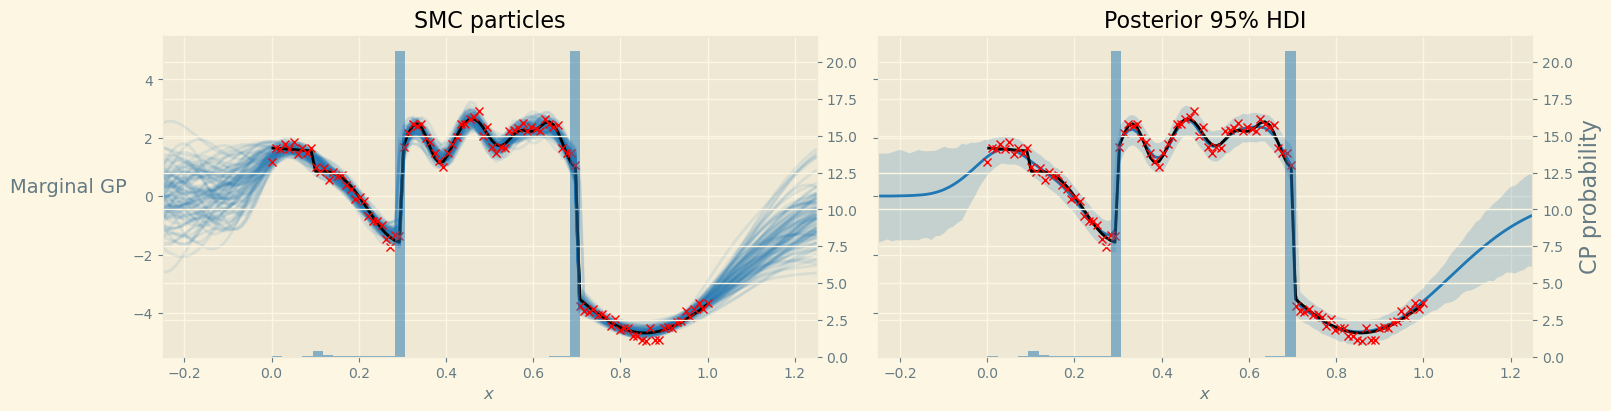

: 

In [9]:
plt.style.use('Solarize_Light2')

x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
f_pred = gp_marginal.predict_f(key_pred, x_pred)

pd = mgp_particles.particles['kernel']['num']
# There are some outliers that skew the axis
# pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
# pd_filtered = jnp.extract(pd>pd_l, pd)
# pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
f_mean = jnp.mean(f_pred, axis=0)
y_pred = gp_marginal.predict_y(key_pred, x_pred)
f_hdi_lower = jnp.percentile(y_pred, q=2.5, axis=0)
f_hdi_upper = jnp.percentile(y_pred, q=97.5, axis=0)
# f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
# f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)

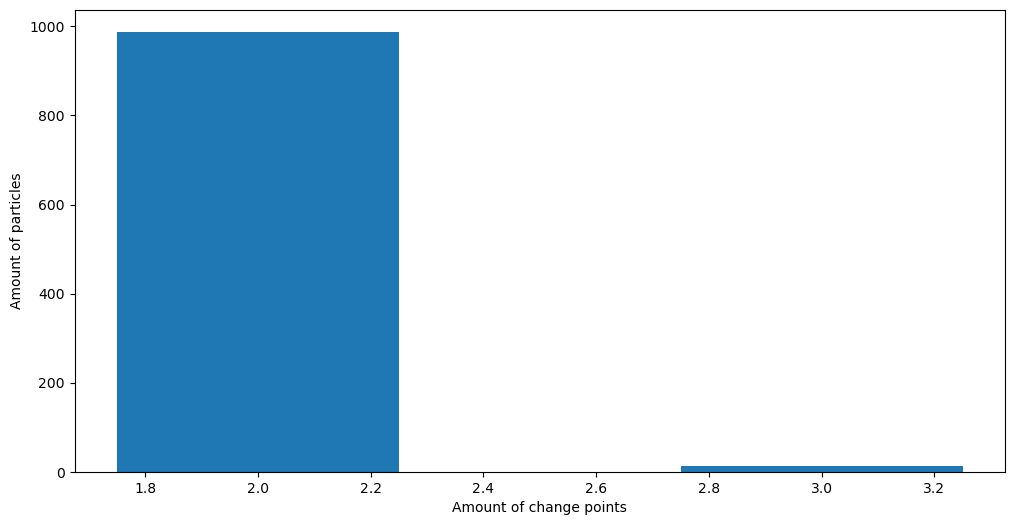

: 

In [18]:
fig = plt.figure(figsize=(12, 6))
num_val = mgp_particles.particles['kernel']['num']
counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts, bins=uni_vals, rwidth = 0.5)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")
plt.show()

In [64]:
num_runs = 10
key, key_pred = jrnd.split(key)

x_pred = jnp.linspace(-0.25, 1.25, num=150)

pd_all = jnp.zeros((num_particles*size, num_runs))
f_pred_all = jnp.zeros((num_particles, 150, num_runs))
for i in range(num_runs):
  print(i)
  key, gpm_key = jrnd.split(key)
  mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps),
                                                                  poisson = True)

  pd_all = pd_all.at[:, i].set(mgp_particles.particles['kernel']['num'].flatten())
  f_pred_all = f_pred_all.at[:, :, i].set(gp_marginal.predict_f(key_pred, x_pred))

0
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
1
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
2
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
3
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
4
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
5
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
6
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
7
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
8
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01
9
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01


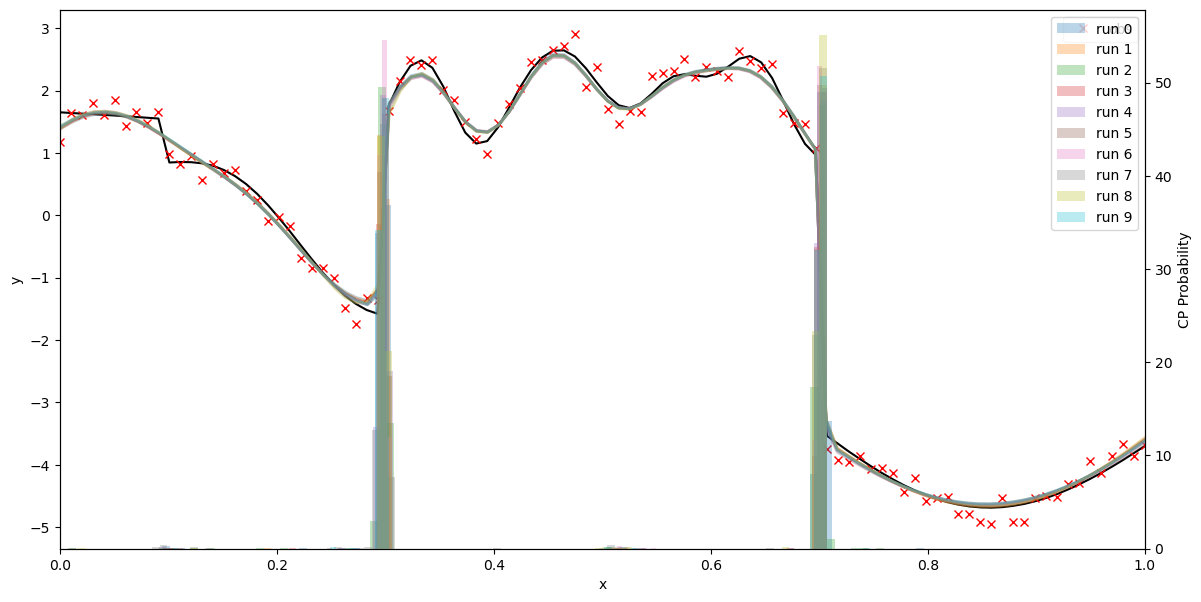

In [66]:
import matplotlib.colors as cm

key = jrnd.PRNGKey(12345)

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([30, 10, 70])/n
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(x, f_true, 'k', label=r'')
ax1.plot(x, y, 'rx', label='obs')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim([0., 1.])
ax1.legend();

# x_pred = jnp.linspace(-0.25, 1.25, num=150)
# f_pred = gp_marginal.predict_f(key_pred, x_pred)

#ax2 = ax1.twinx()
#ax2.hist(pd_all.T, bins=30, density=True, histtype='bar', stacked=True, alpha = 0.5)
#ax2.set_ylabel('CP Probability')
#plt.show()
colors = [cm.to_hex(plt.cm.tab10(i)) for i in range(num_runs)]


ax2 = ax1.twinx()
for i, c in zip(range(num_runs), colors):
  #print(i)
  f_mean = jnp.mean(f_pred_all[:, :, i], axis=0)
  # f_hdi_lower = jnp.percentile(f_pred[:, :, i], q=2.5, axis=0)
  # f_hdi_upper = jnp.percentile(f_pred[:, :, i], q=97.5, axis=0)

  ax1.plot(x_pred, f_mean, color=c, lw=2, alpha = 0.3)
  # ax1.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
  #                 alpha=0.2, color=c, lw=0)
  ax2.hist(pd_all[:, i].T, bins=100, density=True, alpha = 0.3, color = c, label = f'run {i}')
ax2.set_ylabel('CP Probability')
ax2.legend()
# plt.savefig("sample_post_PP_10.png")
# files.download("sample_post_PP_10.png")

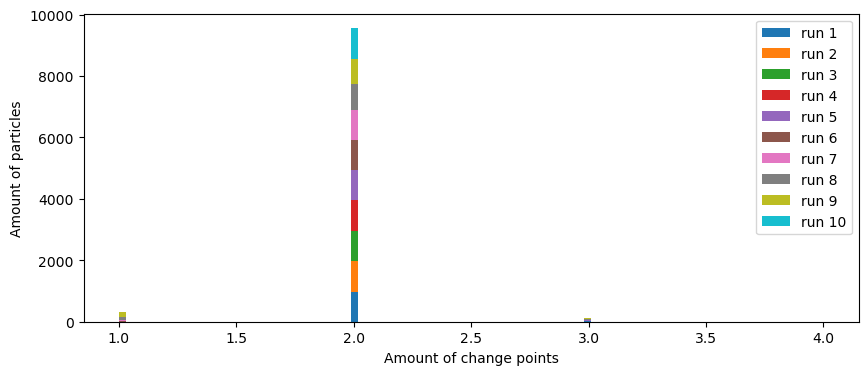

: 

In [67]:
fig = plt.figure(figsize=(10,4))

key, key_pred = jrnd.split(key)

pd_all_new = jnp.reshape(pd_all, (num_particles, size, num_runs))

counts = jnp.zeros((num_particles, num_runs))
for i, c in zip(range(num_runs), colors):
  counts = counts.at[:, i].set(jnp.count_nonzero(~jnp.isnan(pd_all_new[:, :, i]), axis = 1))
  uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))

labels = ["run 1", "run 2", "run 3", "run 4", "run 5", "run 6", "run 7", "run 8", "run 9", "run 10"]

plt.hist(counts.T, bins=100, histtype = 'bar', stacked=True, color = colors, label = labels)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")
plt.legend()
# plt.savefig("num_PP_10.png")
# files.download("num_PP_10.png")

In [68]:
from Normal_modified import LogNormal_mod
key = jrnd.PRNGKey(12345)
testnormal = dx.Normal(0, 1)
samplenorm = testnormal._sample_n(key=key, n = 5000).reshape(5, 1000)
# print(samplenorm.shape)
testuniform = dx.Uniform(0,
                          1)
testval = jnp.array([[0.1, 0.5, -0.1, jnp.nan, jnp.nan]])

# testuniform2 = Uniform_mod(jnp.zeros(5), jnp.zeros(5)+1)
k = testval
testnormal2 = LogNormal_mod(0, 1, max_CP=5)
# sample1 = testuniform2._sample_n(key=key, k=3, n=1)
new_key, key = jrnd.split(key)
sample2 = testnormal2._sample_n(key = new_key, k = k, n = 1)
print(sample2)
print(testnormal2.log_prob(sample2))

# sample1 = testuniform2._sample_n(key=new_key, k=3, n=1)
# print(sample1)
# print(testuniform.log_prob(testval))
# print(testuniform2.log_prob(testval))

[[ 3.99429177  1.11157787 11.24860223  1.61473164         nan]]
[[-3.26273213 -1.0303138  -6.26797261 -1.51290867         nan]]


**Testing Latent**

In [12]:
num_runs = 10

x_pred = jnp.linspace(-0.25, 1.25, num=150)

pd_all = jnp.zeros((num_particles*size, num_runs))
f_pred_all = jnp.zeros((num_particles, 150, num_runs))
for i in range(num_runs):
  print(i)
  key, gpm_key = jrnd.split(key)
  key, gpm_key = jrnd.split(key)
  lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpm_key,
                                                                  mode='gibbs-in-smc',
                                                                  sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

  pd_all = pd_all.at[:, i].set(lgp_particles.particles['kernel']['num'].flatten())
  f_pred_all = f_pred_all.at[:, :, i].set(gp_latent.predict_f(key_pred, x_pred))

0


TypeError: 'NoneType' object is not subscriptable

In [ ]:
import matplotlib.colors as cm

key = jrnd.PRNGKey(12345)

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([30, 10, 70])/n
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        CP=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(x, f_true, 'k', label=r'')
ax1.plot(x, y, 'rx', label='obs')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim([0., 1.])
ax1.legend();

# x_pred = jnp.linspace(-0.25, 1.25, num=150)
# f_pred = gp_marginal.predict_f(key_pred, x_pred)

#ax2 = ax1.twinx()
#ax2.hist(pd_all.T, bins=30, density=True, histtype='bar', stacked=True, alpha = 0.5)
#ax2.set_ylabel('CP Probability')
#plt.show()
colors = [cm.to_hex(plt.cm.tab10(i)) for i in range(num_runs)]


ax2 = ax1.twinx()
for i, c in zip(range(num_runs), colors):
  #print(i)
  f_mean = jnp.mean(f_pred_all[:, :, i], axis=0)
  # f_hdi_lower = jnp.percentile(f_pred[:, :, i], q=2.5, axis=0)
  # f_hdi_upper = jnp.percentile(f_pred[:, :, i], q=97.5, axis=0)

  ax1.plot(x_pred, f_mean, color=c, lw=2, alpha = 0.3)
  # ax1.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
  #                 alpha=0.2, color=c, lw=0)
  ax2.hist(pd_all[:, i].T, bins=100, density=True, alpha = 0.3, color = c, label = f'run {i}')
ax2.set_ylabel('CP Probability')
ax2.legend()
# plt.savefig("sample_post_PP_10.png")
# files.download("sample_post_PP_10.png")